# 1.0 Import Libraries

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler 
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score


# 2.0 Sorting the Data

In [2]:
# df.drop(['team_id', 'champion'], axis = "columns", inplace = True)

# df = df[df['season'] <= MAX_SEASON]

# df['Rk_Conference'] = df.groupby(['season', 'conference'])['W'].rank("min", ascending=False)
# df['Rk_Conference'] = df['Rk_Conference'] + df['Rk_Season']
# df['Rk_Conference'] = df.groupby(['season', 'conference'])['Rk_Conference'].rank("min", ascending=True)
# del df['conference']

# df['Top_3_Conference'] = df['Rk_Conference'].apply(lambda cell: True if cell <=3 else False)
# df.to_csv("champ_data_edit.csv", index=False, encoding="utf-8-sig")

# 3.0 Data Cleaning

In [3]:
df = pd.read_csv("C:/Users/Hezron Ling/Desktop/champ_data_edit.csv", encoding="utf-8-sig", low_memory=False)

In [4]:
df = df[df['season'] <= 2022]

In [5]:
# MAX_SEASON = 2022
# LAST_N_SEASONS = 1

## 3.1 Remove all Null Values

In [6]:
df.isna().any()[lambda x: x]

FG               True
FGA              True
FG%              True
3P               True
3PA              True
                 ... 
Post             True
≤3               True
≥10              True
Over500          True
Rk_Conference    True
Length: 73, dtype: bool

### 3.1.1 Calculate the total number of null values in each season and plot a line graph

In [7]:
nullVal_season = []
nullVal_count = []

for season in df['season'].unique(): 
    nullVal_season.append(season)
    x = sum((df[df['season'] == season].isnull().sum(axis=1)))
    nullVal_count.append(x)

dict = {'season': nullVal_season, 'null_values_count': nullVal_count} 

df_nullCount = pd.DataFrame(dict)

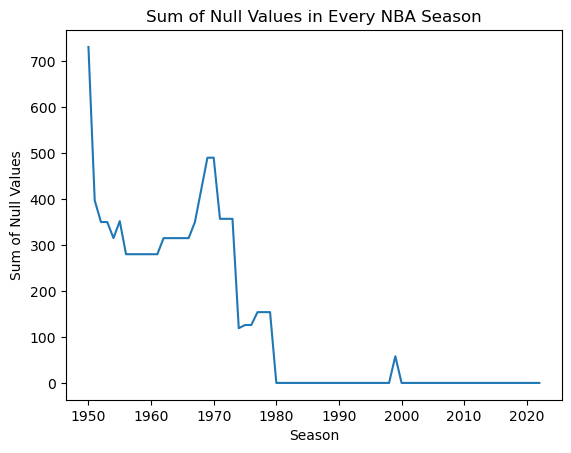

In [8]:
import matplotlib.pyplot as plt
import numpy as np

x = df_nullCount['season']
y = df_nullCount['null_values_count']
 
plt.plot(x, y)
plt.xlabel("Season") 
plt.ylabel("Sum of Null Values")  
plt.title("Sum of Null Values in Every NBA Season")  
plt.show()

### 3.1.2 Remove rows with seasons before 1980

- Most of the advanced stats were not tracked back then before 1980
- The 3 point shot did not exist until 1980, thus there are no stats for it. 

In [9]:
df = df[df['season'] >= 1980]

### 3.1.3 Check for null values shown in graph around the 2000s

In [10]:
df.isna().any()[lambda x: x]

Pre     True
Post    True
dtype: bool

In [11]:
print(' Pre : ', df['Pre'].isnull().sum())
print(' Post : ', df['Post'].isnull().sum())

 Pre :  29
 Post :  29


### 3.1.4 Remove the columns Pre and Post

In [12]:
df = df.drop(['Pre', 'Post'], axis=1)

In [13]:
df.isnull().values.any()

False

In [14]:
df.replace({False: 0, True: 1}, inplace=True)

In [15]:
# df_last = df[df['season'] > (MAX_SEASON - LAST_N_SEASONS)]
# df = df[df['season'] <= (MAX_SEASON - LAST_N_SEASONS)]

In [16]:
df.head()

,season,name,conference,FG,FGA,FG%,3P,3PA,3P%,2P,...,L6YP,L10YP,count_playoff_games,count_champion,sum_mvp_shares,sum_dpoy_shares,count_all_nba,count_all_defensive,Rk_Conference,Top_3_Conference
30,2022,Orlando Magic,East,38.3,88.3,0.434,12.2,36.9,0.331,26.1,...,0.1250,0.1875,0.0,0.0,0.000,0.000,0.0,0.0,15.0,0
31,2022,Atlanta Hawks,East,41.5,88.3,0.470,12.9,34.4,0.374,28.6,...,1.0000,1.9375,271.0,0.0,0.000,0.024,0.0,0.0,9.0,0
32,2022,Utah Jazz,West,40.6,86.2,0.471,14.5,40.3,0.360,26.0,...,1.1875,1.1875,296.0,0.0,0.010,3.803,4.0,7.0,5.0,0
33,2022,Boston Celtics,East,40.7,87.4,0.466,13.2,37.1,0.356,27.5,...,2.3750,3.1875,398.0,0.0,0.001,0.107,2.0,3.0,2.0,1
34,2022,Indiana Pacers,East,41.4,89.5,0.463,12.2,35.4,0.344,29.3,...,0.3750,2.0625,0.0,0.0,0.000,0.000,0.0,0.0,13.0,0


# 4.0 Feature Selection

In [17]:
NUM_OF_FEAT = 15

## 4.1 Filter Based Approach

### 4.1.1 Pearson's Correlation (HeatMap) 
- Since there are too many features, it is difficult to use HeatMap for feature selection

In [18]:
# import matplotlib.pyplot as plt
# heatmap_data = df.corr()
# plt.figure(figsize=(20, 20))
# sns.heatmap(heatmap_data, cmap = "BuPu", annot = True)

### 4.1.2 ANOVA

In [19]:
# Define the features and the target variable
X = df.drop(['Champion_Win_Share', 'Champion_Percent', 'name', 'conference'], axis = 1)
y = df['Champion_Win_Share']

In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

fs = SelectKBest(score_func=f_regression, k='all')
fit = fs.fit(X, y)

In [21]:
features_score = pd.DataFrame(fit.scores_)
features_pvalue = pd.DataFrame(np.round(fit.pvalues_, 4))
features = pd.DataFrame(X.columns)
df_featureScore = pd.concat([features, features_score], axis=1)

df_featureScore.columns = ["CWS_Features", "F_Score"]
df_featureScore = df_featureScore.nlargest(NUM_OF_FEAT, columns="F_Score")

In [22]:
ANOVA_top_features = df_featureScore['CWS_Features'].tolist()

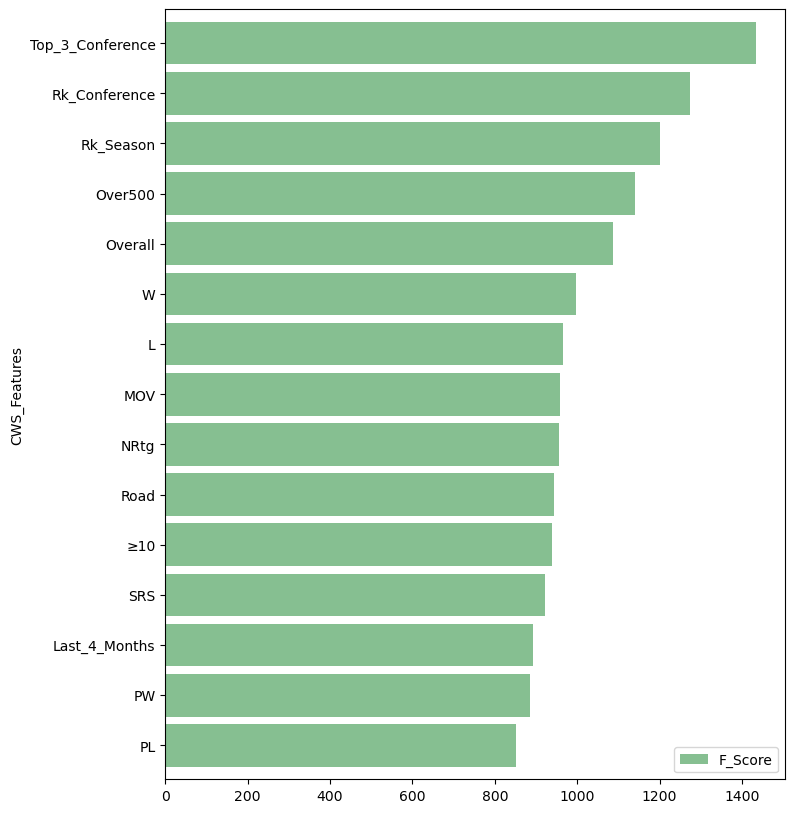

In [23]:
df_featureScore.sort_values('F_Score', inplace=True)

ax =  df_featureScore.plot(kind='barh', figsize=(8, 10), 
                           color='#86bf91', zorder=2, width=0.85, 
                           x='CWS_Features', y='F_Score')

### 4.1.3 Chi Squared Value

In [24]:
# from sklearn.feature_selection import chi2
# from sklearn.preprocessing import LabelEncoder

In [25]:
# chiSquare_X = df.drop(['Champion_Win_Share', 'Champion_Percent', 'name', 'conference'], axis = 1)
# chiSquare_y = df['Champion_Win_Share']

In [26]:
# label_encoder = LabelEncoder()
# df['name'] = label_encoder.fit_transform(df['name'])
# df['conference'] = label_encoder.fit_transform(df['conference'])

In [27]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

In [28]:
# df_ChiSquare_X = df_scaled.drop(['Champion_Win_Share', 'Champion_Percent'], axis = 1)
# df_ChiSquare_y = df_scaled['Champion_Win_Share']

In [29]:
# df_ChiSquare_y.head()

In [30]:
# chi_scores = chi2(df_ChiSquare_X, df_ChiSquare_y)
# chi_scores #first array shows the chi square values and second array shows the p value

### 4.1.4 Mutual Info Regression

In [31]:
from sklearn.feature_selection import mutual_info_regression

In [32]:
mir = mutual_info_regression
mutual_info = mir(X, y)

In [33]:
features_mi = pd.DataFrame(np.round(mutual_info, 4))
df_features_mi = pd.concat([features, features_mi], axis=1)
df_features_mi.columns = ["MI_Features", "Mutual_Info"]
df_features_mi = df_features_mi.nlargest(NUM_OF_FEAT, columns="Mutual_Info")

In [34]:
MIR_top_features = df_features_mi['MI_Features'].tolist()

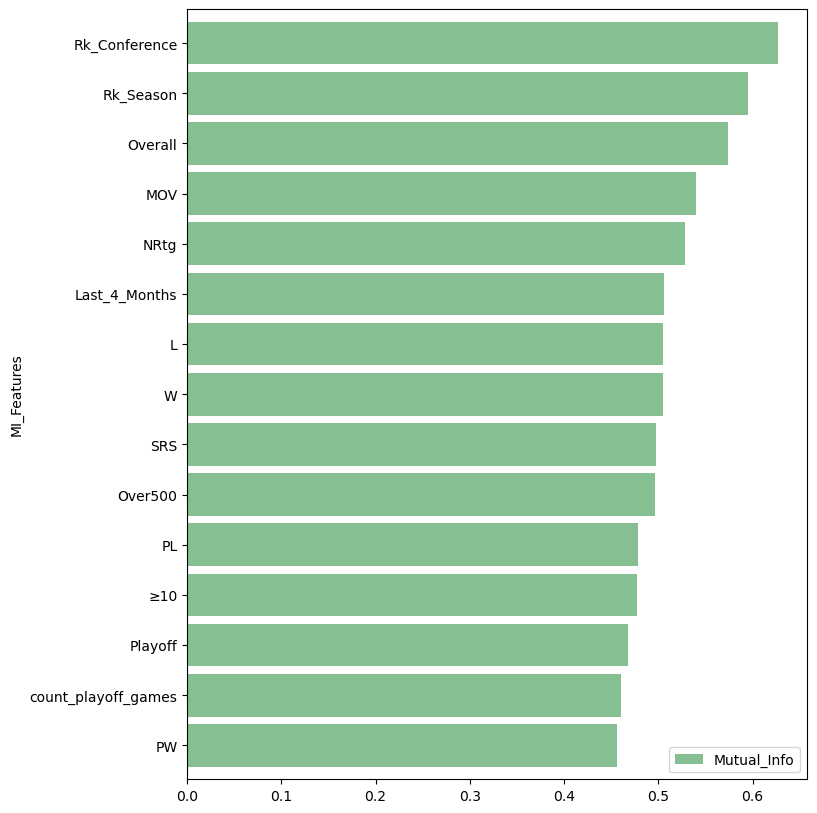

In [35]:
df_features_mi.sort_values('Mutual_Info', inplace=True)

ax =  df_features_mi.plot(kind='barh', figsize=(8, 10), 
                           color='#86bf91', zorder=2, width=0.85, 
                           x='MI_Features', y='Mutual_Info')

## 4.2 Wrapper Based Approach

In [36]:
X = df.drop(['name', 'conference', 'Champion_Win_Share', 'Champion_Percent'], axis = 1)
y = df['Champion_Win_Share']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### 4.2.1 Exhaustive Feature Selector

In [37]:
# from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.ensemble import RandomForestRegressor

In [38]:
# efs = EFS(RandomForestRegressor(), 
#           min_features = 5, 
#           max_features = 20,  
#           scoring = 'r2', 
#           print_progress=True,
#           cv = 5,
#           n_jobs = -1)

# efs.fit(X_train, y_train)

In [39]:
# print("Best features: ", efs.best_feature_names_)

In [40]:
# print("Highest r2 score: ", efs.best_score_)

In [41]:
# df_EFS = pd.DataFrame.from_dict(efs.get_metric_dict()).T

### 4.2.2 Sequential Forward Selection

In [42]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [43]:
# sfs = SFS(RandomForestRegressor(), 
#           k_features = 20, 
#           forward = True, 
#           floating = True, 
#           verbose = 2, 
#           scoring = 'r2', 
#           cv = 5,
#           n_jobs = -1)

# sfs.fit(X_train, y_train)

In [44]:
# print("Features: ", sfs.k_feature_names_)

In [45]:
# print("r2 score: ", sfs.k_score_)

In [46]:
# df_SFS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
# df_SFS.tail()

In [47]:
SFS_top_features = ['2P%', 'DRB', 'FG%_opp', '3PA_opp',
            'ORB_opp', 'L', 'PL', '3PAr', 'Defense Four Factors|TOV%', 'Defense Four Factors|DRB%',
            'Rk_Season', 'Over500', 'Playoff', 'count_playoff_games', 'Rk_Conference']

SFS_top_features.reverse()

### 4.2.3 Sequential Backward Selection

In [48]:
# sbs = SFS(RandomForestRegressor(), 
#           k_features = 20, 
#           forward = False, 
#           floating = True, 
#           verbose = 2, 
#           scoring = 'r2', 
#           cv = 5,
#           n_jobs = -1)

# sbs.fit(X_train, y_train)

In [49]:
# print("Features: ", sbs.k_feature_names_)

In [50]:
# print("r2 score: ", sbs.k_score_)

In [51]:
# df_SBS = pd.DataFrame.from_dict(sbs.get_metric_dict()).T

In [52]:
SBS_top_features = ['FGA_opp', 'FT_opp', 'TOV_opp', 'PW', 'PL', 'SRS', 'Offense Four Factors|eFG%', 
                    'Offense Four Factors|TOV%', 'Defense Four Factors|DRB%', 'Rk_Season', 'Over500', 
                    'count_playoff_games', 'sum_mvp_shares', 'Rk_Conference', 'Top_3_Conference']

SBS_top_features.reverse()

## 4.3 Embedded Approach

### 4.3.1 Genetic Algorithms

### 4.3.2 LASSO

In [53]:
from sklearn.linear_model import Lasso

In [54]:
# parameters to be tested on GridSearchCV
params = {'max_iter': [50, 100, 200, 500], 'alpha': [0.00001, 0.0001, 0.001, 0.01]}

# Number of Folds and adding the random state for replication
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()

# GridSearchCV with model, params and folds.
lasso_cv = GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X_train, y_train)
print("Best Param:", lasso_cv.best_params_)

C:\Users\Hezron Ling\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.799e+00, tolerance: 6.043e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Hezron Ling\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.402e+00, tolerance: 5.896e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\Hezron Ling\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8

Best Param: {'alpha': 0.001, 'max_iter': 50}


C:\Users\Hezron Ling\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.118e+01, tolerance: 7.334e-03
  model = cd_fast.enet_coordinate_descent(


In [55]:
# calling the model with the best parameter
lasso1 = Lasso(alpha= 0.001, max_iter = 50)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_) 

C:\Users\Hezron Ling\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.118e+01, tolerance: 7.334e-03
  model = cd_fast.enet_coordinate_descent(


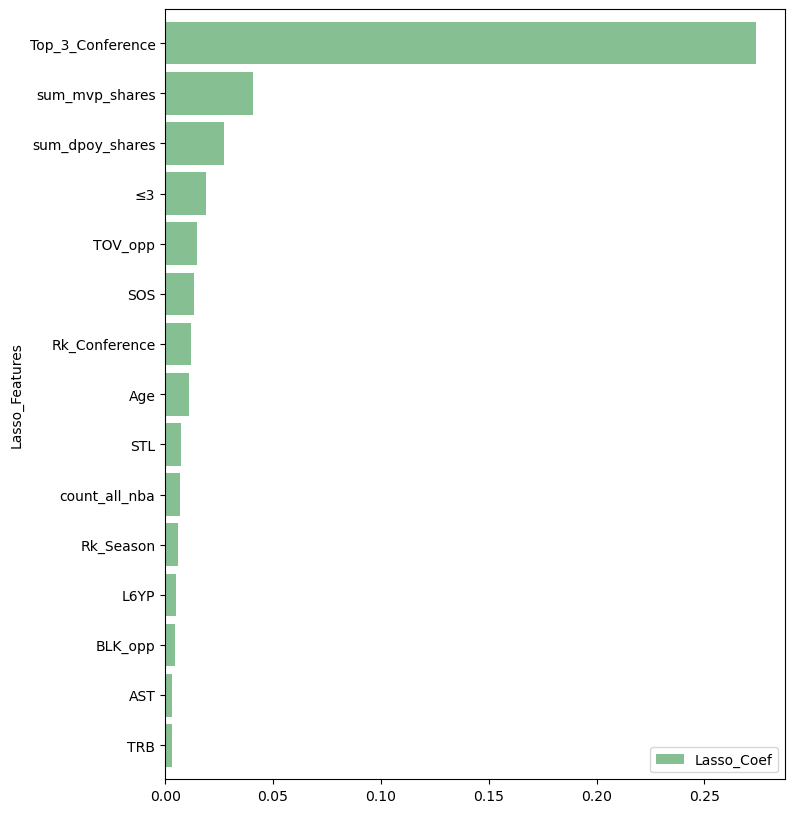

In [56]:
features_lasso = pd.DataFrame(np.round(lasso1_coef, 4))
df_features_lasso = pd.concat([features, features_lasso], axis=1)
df_features_lasso.columns = ["Lasso_Features", "Lasso_Coef"]
df_features_lasso = df_features_lasso.nlargest(NUM_OF_FEAT, columns="Lasso_Coef")

LASSO_top_features = df_features_lasso['Lasso_Features'].tolist()

LASSO_top_features = df_features_lasso['Lasso_Features'].tolist()

df_features_lasso.sort_values('Lasso_Coef', inplace=True)

ax =  df_features_lasso.plot(kind='barh', figsize=(8, 10), 
                           color='#86bf91', zorder=2, width=0.85, 
                           x='Lasso_Features', y='Lasso_Coef')

### 4.3.3 Random Forest Regressor

In [57]:
rf = RandomForestRegressor(random_state=0)

rf.fit(X_train, y_train)

f_i = list(zip(X,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])

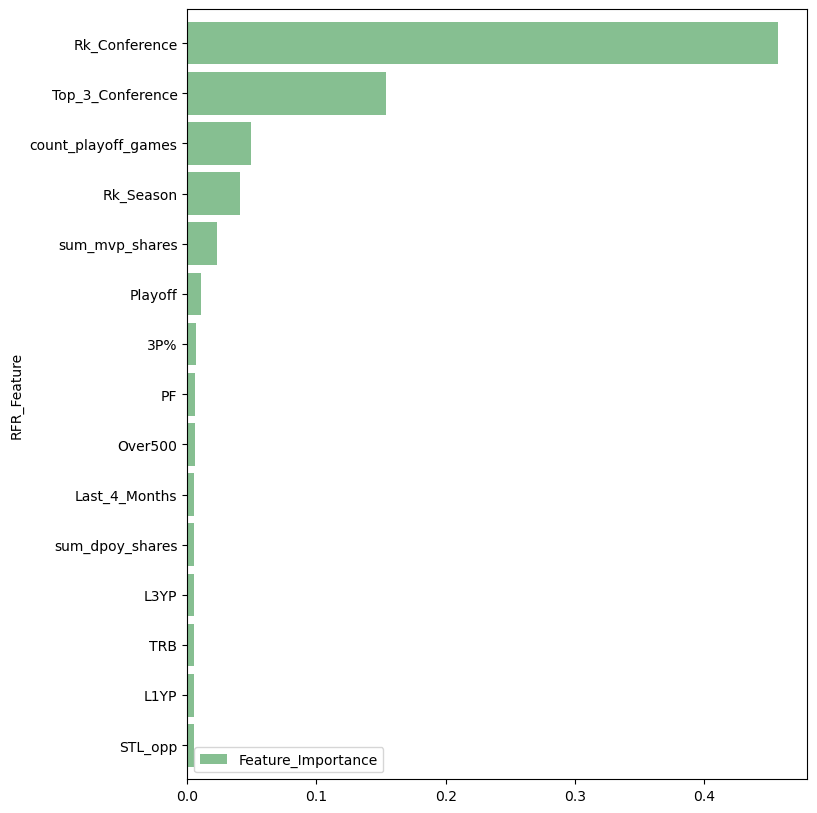

In [58]:
df_RFR = pd.DataFrame(f_i, columns=['RFR_Feature', 'Feature_Importance'])
df_RFR = df_RFR.nlargest(NUM_OF_FEAT, columns="Feature_Importance")
df_RFR.sort_values('Feature_Importance', inplace=True)

RFR_top_features = df_RFR['RFR_Feature'].tolist()

ax =  df_RFR.plot(kind='barh', figsize=(8, 10), 
                           color='#86bf91', zorder=2, width=0.85, 
                           x='RFR_Feature', y='Feature_Importance')

In [59]:
RFR_top_features.reverse()

# 5.0 Features and Models Evaluation

In [60]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(dataset):
    vif = pd.DataFrame()
    vif["features"] = dataset.columns
    vif["VIF_Value"] = [variance_inflation_factor(dataset.values, i) for i in range(dataset.shape[1])]
    
    return(vif)

## 5.1 Common Features in all methods

In [62]:
# ANOVA_top_features
# MIR_top_features
# SFS_top_features
# SBS_top_features
# LASSO_top_features
# RFR_top_features

all_features = ANOVA_top_features + MIR_top_features + SFS_top_features + SBS_top_features + LASSO_top_features + RFR_top_features

from collections import Counter
all_features = Counter(all_features)
all_features = sorted(all_features.items(), key=lambda item: item[1], reverse=True)

In [63]:
print(all_features)

[('Rk_Conference', 6), ('Rk_Season', 6), ('Over500', 5), ('Top_3_Conference', 4), ('PL', 4), ('count_playoff_games', 4), ('L', 3), ('SRS', 3), ('Last_4_Months', 3), ('PW', 3), ('Playoff', 3), ('sum_mvp_shares', 3), ('Overall', 2), ('W', 2), ('MOV', 2), ('NRtg', 2), ('≥10', 2), ('Defense Four Factors|DRB%', 2), ('TOV_opp', 2), ('sum_dpoy_shares', 2), ('TRB', 2), ('Road', 1), ('Defense Four Factors|TOV%', 1), ('3PAr', 1), ('ORB_opp', 1), ('3PA_opp', 1), ('FG%_opp', 1), ('DRB', 1), ('2P%', 1), ('Offense Four Factors|TOV%', 1), ('Offense Four Factors|eFG%', 1), ('FT_opp', 1), ('FGA_opp', 1), ('≤3', 1), ('SOS', 1), ('Age', 1), ('STL', 1), ('count_all_nba', 1), ('L6YP', 1), ('BLK_opp', 1), ('AST', 1), ('3P%', 1), ('PF', 1), ('L3YP', 1), ('L1YP', 1), ('STL_opp', 1)]


In [64]:
common_top_features = ['Rk_Conference',  # the ranking in their conference
                     'Rk_Season', # the ranking in the season 
                     'Over500', #
                     'Top_3_Conference', # are they in the top 3
                     'PL', # projected losses
                     'count_playoff_games', # total number of playoff games played by the players in the team
                     'L', # number of losses
                     'SRS', # SRS - Simple Rating System
                     'Last_4_Months', # the winning percentage in the last 4 months of the season
                     'PW', # projected wins
                     'Playoff',# are they in the playoffs
                     'sum_mvp_shares',# total MVP shares in the team
                     'Overall',
                     'W', 
                     'MOV',
                     'NRtg',
                     '≥10',
                     'Defense Four Factors|DRB%',
                     'TOV_opp',
                     'sum_dpoy_shares',
                     'TRB' 
                      ]

### 5.1.1 XGB

- the results showed a near perfect accuracy in the training set (0.99), but an average accuracy in the test set (0.5-0.6) with   an MSE score of about 0.16-0.2
- the difference between the train accuracy and test accuracy is too significant
- this shows that this model is overfitting and will not be used in section 6.0 Modelling 

In [65]:
from xgboost import XGBRegressor
XGB = XGBRegressor()

In [66]:
def num_of_features(num, top_feat): 
    top_features = []
    for i in range (4,num+4):
        for feature in top_feat: 
            top_features.append(feature)
            if feature == top_feat[num-1]:
                X = df[top_features]
                return X
                break;

In [67]:
def Feature_Evaluation(clf, num_feat, features):
    # Split training and testing set
    X = num_of_features(num_feat, features) #num of features selected
    y = df['Champion_Win_Share']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.125, random_state = 42)
    
    clf.fit(X_train, y_train)
    clf_test_pred = clf.predict(X_test)
    clf_train_pred = clf.predict(X_train) 
    clf_val_pred = clf.predict(X_val) 
    r2_train = r2_score(y_train, clf_train_pred)
    r2_test = r2_score(y_test, clf_test_pred, multioutput='variance_weighted')
    r2_val = r2_score(y_val, clf_val_pred)
    RMSE = mean_squared_error(y_test, clf_test_pred, squared = False, multioutput='uniform_average')
#     NCDG = ndcg_score(y_test, clf_test_pred)
    return r2_train, r2_test, r2_val, RMSE

In [68]:
def Evaluate_Num_of_Features(clf, features):
    for i in range (4, len(features)+1):
        r2_train, r2_test, r2_val, RMSE = Feature_Evaluation(clf, i, features)
        print ("Top", i, "Features: ", "r2_train = ", r2_train, "r2_test = ", r2_test, "r2_val = ", r2_val, "RMSE_test = ", RMSE)

In [69]:
# Evaluate_Num_of_Features(XGB, common_top_features)

### 5.1.2 LightGBM

- the results showed a good accuracy in the training set (0.8-0.95), it increases as the number of features increases
- however it has an average accuracy in the test set (0.59-0.65) with an average MSE score of about 0.15-0.16
- this model is performed pretty well, however RFR outperforms this model 

In [70]:
from lightgbm import LGBMRegressor
LGBM = LGBMRegressor()

In [71]:
# Evaluate_Num_of_Features(LGBM, common_top_features)

### 5.1.3 RFR

- the results showed a good accuracy in the training set (0.92-0.95) the accuracy peaked at 0.97 as it reaches 7 features
- RFR also produced the highest accuracy in the test set (0.55-0.68) with  an MSE score of about 0.14-0.17
- the highest test accuracy with the lowest MSE peaked at round 14 features
- this shows that this model performs well and will be used in section 6.0 Modelling 

In [72]:
from sklearn.ensemble import RandomForestRegressor
RFR =  RandomForestRegressor(random_state = 42)

In [73]:
Evaluate_Num_of_Features(RFR, common_top_features)

Top 4 Features:  r2_train =  0.9232048269550304 r2_test =  0.5840309804391526 r2_val =  0.5662586613981739 RMSE_test =  0.1714283551904144
Top 5 Features:  r2_train =  0.9490797274704883 r2_test =  0.5612387305775729 r2_val =  0.6188917661196875 RMSE_test =  0.17606227409903535
Top 6 Features:  r2_train =  0.9532406571894425 r2_test =  0.6257472587525252 r2_val =  0.6451395785743699 RMSE_test =  0.16260528613639197
Top 7 Features:  r2_train =  0.9537773969367209 r2_test =  0.6302370251849323 r2_val =  0.6494382798886307 RMSE_test =  0.1616269866220042
Top 8 Features:  r2_train =  0.9526319219275534 r2_test =  0.6279819177052206 r2_val =  0.6369558650304382 RMSE_test =  0.16211910212305916
Top 9 Features:  r2_train =  0.9538630571231137 r2_test =  0.6371516043508512 r2_val =  0.6119936921465909 RMSE_test =  0.16010863999484706
Top 10 Features:  r2_train =  0.9545771250967863 r2_test =  0.6441602017266888 r2_val =  0.6098991473194038 RMSE_test =  0.15855481112476924
Top 11 Features:  r2_

### 5.1.4 Stacked Generalisation Regression (RFR, LGBM) 

In [74]:
from sklearn.ensemble import StackingRegressor

In [75]:
# level_1 = [('RFR', RFR), ('LGBM', LGBM)] #level 1 has 2 algorithms
level_2 = LGBM
level_1 = [('RFR', RFR)]
stack_model = StackingRegressor(estimators = level_1, final_estimator = level_2, cv = 5)

In [76]:
stack_model = StackingRegressor(estimators = level_1, final_estimator = level_2, cv = 5)

In [77]:
# Evaluate_Num_of_Features(stack_model, common_top_features)

## 5.2 Features from all methods

In [78]:
# ANOVA_top_features
# MIR_top_features
# SFS_top_features
# SBS_top_features
# LASSO_top_features
# RFR_top_features

### 5.2.1 ANOVA

In [79]:
# Evaluate_Num_of_Features(RFR, ANOVA_top_features)

### 5.2.2 Mutual Info Regression

In [80]:
# Evaluate_Num_of_Features(RFR, MIR_top_features)

### 5.2.3 Sequential Forward Selector

In [81]:
# Evaluate_Num_of_Features(RFR, SFS_top_features)

### 5.2.4 Sequential Backward Selector

In [82]:
# Evaluate_Num_of_Features(RFR, SBS_top_features)

### 5.2.5 LASSO

- top 8 features produced highest accuracy
- the top 8 features of LASSO will be chosen as the features 

In [83]:
# # top 9 features are = 
# ['Top_3_Conference',
#  'sum_mvp_shares',
#  'sum_dpoy_shares',
#  'TOV_opp',
#  'SOS',
#  'Rk_Conference',
#  'Age',
#  'STL'
#  'count_all_nba']

In [84]:
#this feature was removed because it has no description, and the results were still similar after removing it
LASSO_top_features.remove('≤3') 

In [85]:
Evaluate_Num_of_Features(RFR, LASSO_top_features)

Top 4 Features:  r2_train =  0.9149975044067273 r2_test =  0.5955786750961929 r2_val =  0.661871948061127 RMSE_test =  0.16903210066887514
Top 5 Features:  r2_train =  0.938202093061475 r2_test =  0.5790888614852822 r2_val =  0.6163743149570776 RMSE_test =  0.1724437165201186
Top 6 Features:  r2_train =  0.9525628137387466 r2_test =  0.660102109893878 r2_val =  0.6523374162800952 RMSE_test =  0.154962423320021
Top 7 Features:  r2_train =  0.9544637221188766 r2_test =  0.6783184770870594 r2_val =  0.6492308752985259 RMSE_test =  0.15075274299614713
Top 8 Features:  r2_train =  0.9529828099670384 r2_test =  0.6849240539814514 r2_val =  0.642852123598115 RMSE_test =  0.14919689652913723
Top 9 Features:  r2_train =  0.9540404469831071 r2_test =  0.6733500935076235 r2_val =  0.6332357511199231 RMSE_test =  0.1519124731125036
Top 10 Features:  r2_train =  0.9546227659407089 r2_test =  0.6569960774701638 r2_val =  0.648448106502171 RMSE_test =  0.15566884682698415
Top 11 Features:  r2_train =

### 5.2.7 RFR

In [86]:
# Evaluate_Num_of_Features(RFR, RFR_top_features)

## 5.3 Lasso features based on VIF

- after removing features with a VIF value higher than 10, the results were worse than the top 8 features used
- therefore VIF will not be used to determine the feature importance

In [87]:
# features = df[LASSO_top_features]
# calculate_vif(features)

In [88]:
# LASSO_top_features_VIF = [
#                      'Top_3_Conference', # are they in the top 3
#                      'sum_mvp_shares',# total MVP shares in the team
#                      'sum_dpoy_shares',
#                      'SOS',
#                      'count_all_nba', 
#                      'L6YP'
#                        ]

# 5.0 Hyperparameter Optimization (RFR) 

In [89]:
top_8_LASSO_feat = [ 'Top_3_Conference',
                     'sum_mvp_shares',
                     'sum_dpoy_shares',
                     'TOV_opp',
                     'SOS',
                     'Rk_Conference',
                     'Age',
                     'STL'
                   ]

In [90]:
X = df[top_8_LASSO_feat]  #num of features selected
y = df['Champion_Win_Share']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

In [91]:
# search_space = {
# #     "n_estimators" : [50, 100, 250, 500],
#     "n_estimators" : [10, 20, 30, 40, 50],
# #     "n_estimators" : [6, 8, 10, 14, 16],
# #     "max_depth" : [6, 8, 10, 12, 14, 16],
#     "max_depth" : [5, 10, 15, 20],
#     "min_samples_split" : [2, 4, 6, 8, 10],
#     "min_samples_leaf": [2, 4, 6, 8, 10],
#     "random_state": [0, 42]
# }

search_space = {
#     'n_estimators': [10, 15, 20, 25, 30],
    'n_estimators': [10, 11, 12, 13, 14],
    'max_depth' : [2,4,6,8,10],
    'min_samples_split' : [2,3,4,5,6,7,8,9,10],
    'min_samples_leaf' : [2,3,4,5,6,7,8,9,10],
    'random_state' : [0, 42]
}

## 5.1 Grid Search

- produced the 2nd best parameters

In [92]:
from sklearn.model_selection import GridSearchCV

def gridSearchCV(model, parameters, num_of_iter, X, y):
    gridsearch = GridSearchCV(estimator = model, param_grid = parameters, n_jobs = -1, cv = 5, verbose = 4, scoring = ['r2'], refit = 'r2')
    gridsearch.fit(X, y)
    best_params =  gridsearch.best_params_
    best_score =  gridsearch.best_score_
    return best_params, best_score

In [93]:
# GS_best_params, GS_best_score = gridSearchCV(RFR, search_space, 40, df[top_8_LASSO_feat], df['Champion_Win_Share'])

In [94]:
# print (GS_best_params, GS_best_score)

In [95]:
# {'max_depth': 4, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 10, 'random_state': 0} 0.6942057329312536

## 5.2 Random Search

In [96]:
from sklearn.model_selection import RandomizedSearchCV

def randomSearchCV(model, parameters, num_of_iter, X, y):
    rdmsearch = RandomizedSearchCV(model, param_distributions = parameters, n_jobs = -1, n_iter = num_of_iter, cv = 5, verbose = 4)
    rdmsearch.fit(X, y)
    best_params = rdmsearch.best_params_
    best_score = rdmsearch.best_score_
    return best_params, best_score

In [97]:
# RS_best_params, RS_best_score = randomSearchCV(RFR, search_space, 40, df[top_8_LASSO_feat], df['Champion_Win_Share'])

In [98]:
# print (RS_best_params, RS_best_score)

In [99]:
# {'random_state': 0, 'n_estimators': 10, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_depth': 4} 0.6915297770479276

## 5.3 Halving

### 5.3.1 Grid Search

In [100]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

def gridSearchCV_halving(model, parameters, X, y):
    gridsearch_halve = HalvingGridSearchCV(  estimator = model, 
                                             param_grid = parameters, 
                                             n_jobs = -1, 
                                             cv = 5, 
                                             verbose = 4, 
                                             scoring = 'r2',
                                             refit = True
#                                              error_score = 'raise'
#                                              n_iterations = 40
                                             )
    gridsearch_halve.fit(X, y)
    best_params =  gridsearch_halve.best_params_
    best_score =  gridsearch_halve.best_score_
    return best_params, best_score

In [101]:
# HGS_best_params, HGS_best_score = gridSearchCV_halving(RFR, search_space, df[top_8_LASSO_feat], df['Champion_Win_Share'])

In [102]:
# print (HGS_best_params, HGS_best_score)

In [103]:
# {'max_depth': 4, 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 12, 'random_state': 0} 0.659912004385198

In [104]:
# this is with 6 features
# {'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 40, 'random_state': 42} 0.7028997686773587

### 5.3.2 Randomized Search

- produced the best parameters

In [105]:
from sklearn.model_selection import HalvingRandomSearchCV

def RandomSearchCV_halving(model, parameters, X, y):
    randomsearch_halve = HalvingRandomSearchCV(  estimator = model, 
                                             param_distributions = parameters, 
                                             n_jobs = -1, 
                                             cv = 5, 
                                             verbose = 4, 
                                             scoring = 'r2',
                                             refit = True
#                                              error_score = 'raise'
#                                              n_iterations = 40
                                             )
    randomsearch_halve.fit(X, y)
    best_params =  randomsearch_halve.best_params_
    best_score =  randomsearch_halve.best_score_
    return best_params, best_score

In [106]:
# HRS_best_params, HRS_best_score = RandomSearchCV_halving(RFR, search_space, df[top_8_LASSO_feat], df['Champion_Win_Share'])

In [107]:
# print (HRS_best_params, HRS_best_score)

In [108]:
# {'random_state': 0, 'n_estimators': 10, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 4} 0.6958926354905433

## 5.5 HyperOpt-Sklearn

- produced same paramters as GridsearchCV

In [109]:
from hyperopt import hp, Trials, fmin, tpe, STATUS_OK

In [110]:
hyper_space = {
    'n_estimators': hp.choice("n_estimators", [10,11,12,13,14,15,16,17,18,19,20]),
    'max_depth' : hp.choice("max_depth", [2,3,4,5,6,7,8,9,10]),
    'min_samples_split' : hp.choice("min_samples_split", [2,3,4,5,6,7,8,9,10]),
    'min_samples_leaf' : hp.choice("min_samples_leaf", [2,3,4,5,6,7,8,9,10]),
    'random_state' : hp.choice("random_state", [0, 42])
}

In [111]:
def HyperOpt(hyper_space):
    RFR_Hyper = RandomForestRegressor(n_estimators = hyper_space['n_estimators'],
                                      max_depth = hyper_space['max_depth'],
                                      min_samples_split = hyper_space['min_samples_split'],
                                      min_samples_leaf = hyper_space['min_samples_leaf'],
                                      random_state = hyper_space['random_state'],
                                      n_jobs=-1)
    acc = cross_val_score(RFR_Hyper, X, y, error_score='raise', cv = 5).mean()
    return {"loss": -acc, "status": STATUS_OK}

In [112]:
# trials = Trials()

# best = fmin(
#     fn = HyperOpt,
#     space = hyper_space, 
#     algo = tpe.suggest, 
#     max_evals = 100, 
#     trials = trials
# )

# print("Best: {}".format(best))

In [113]:
# HyperOpt return list format
# Best: {'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 0, 'n_estimators': 0, 'random_state': 0}

## 5.6 Bayes Search

# 7.0 Hyperparameter Evaluation

- Halving Random Search and Grid Search produced the best parameters
- this section compares the r2 score and the RMSE

## 7.1 Grid Search

In [114]:
# {'max_depth': 4, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 10, 'random_state': 0}

In [115]:
RFR_GS = RandomForestRegressor(max_depth = 4, min_samples_leaf = 7, min_samples_split = 2, n_estimators = 10, random_state = 0)

In [116]:
Evaluate_Num_of_Features(RFR_GS, LASSO_top_features)

Top 4 Features:  r2_train =  0.6745938961047868 r2_test =  0.6466897737179043 r2_val =  0.6727132785885637 RMSE_test =  0.15799024366801204
Top 5 Features:  r2_train =  0.6854984444564012 r2_test =  0.638681858602916 r2_val =  0.6603834856513046 RMSE_test =  0.15977066717275593
Top 6 Features:  r2_train =  0.7460784222963341 r2_test =  0.7076926433579962 r2_val =  0.6568619558219468 RMSE_test =  0.14370505251868818
Top 7 Features:  r2_train =  0.7504906753216285 r2_test =  0.7110978103184374 r2_val =  0.64354728311043 RMSE_test =  0.14286557113062617
Top 8 Features:  r2_train =  0.7524515262664522 r2_test =  0.7083532636373013 r2_val =  0.633081784230646 RMSE_test =  0.14354257256581082
Top 9 Features:  r2_train =  0.7525005332966246 r2_test =  0.7090894810002488 r2_val =  0.6209682063439006 RMSE_test =  0.14336128250205304
Top 10 Features:  r2_train =  0.7615322912177169 r2_test =  0.693788427325771 r2_val =  0.6506614207745433 RMSE_test =  0.14708316442499217
Top 11 Features:  r2_tra

## 7.2 Halving Random Search

In [117]:
# {'random_state': 0, 'n_estimators': 10, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 4}

In [118]:
RFR_HRS = RandomForestRegressor(max_depth = 4, min_samples_leaf = 5, min_samples_split = 5, n_estimators = 10, random_state = 0)

In [119]:
Evaluate_Num_of_Features(RFR_HRS, LASSO_top_features)

Top 4 Features:  r2_train =  0.6770445641023345 r2_test =  0.6394039306907519 r2_val =  0.6767858661185349 RMSE_test =  0.15961094140535753
Top 5 Features:  r2_train =  0.6890684743020226 r2_test =  0.6284819749165125 r2_val =  0.6492133396009414 RMSE_test =  0.16201010730405585
Top 6 Features:  r2_train =  0.7526753903722149 r2_test =  0.7035603179366923 r2_val =  0.6525442744219421 RMSE_test =  0.14471726103893506
Top 7 Features:  r2_train =  0.7580658445994696 r2_test =  0.7114399150109181 r2_val =  0.6365356313560815 RMSE_test =  0.1427809586536812
Top 8 Features:  r2_train =  0.7587634424443153 r2_test =  0.7121684033975044 r2_val =  0.6251766570871 RMSE_test =  0.14260061492929751
Top 9 Features:  r2_train =  0.7579322103112205 r2_test =  0.709619222388423 r2_val =  0.6147103217372227 RMSE_test =  0.14323069422041593
Top 10 Features:  r2_train =  0.7669255643569031 r2_test =  0.692234834737596 r2_val =  0.6541534806207794 RMSE_test =  0.1474558123409729
Top 11 Features:  r2_train

## 7.3 HyperOpt-Sklearn

- produced the same results as GridSearchCV, however it was way more efficient than GridSearchCV

In [120]:
# HyperOpt return list format
# Best: {'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 0, 'n_estimators': 0, 'random_state': 0}

# 8.0 Modelling

- Random Forest Regression 
- Top 7 Features will be used
- Parameters used will be from HyperOpt-Sklearn

In [121]:
top_7_LASSO_feat = [ 'Top_3_Conference',
                     'sum_mvp_shares',
                     'sum_dpoy_shares',
                     'TOV_opp',
                     'SOS',
                     'Rk_Conference',
                     'Age'
                   ]

In [122]:
X = df[top_7_LASSO_feat]
y = df['Champion_Win_Share']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

In [123]:
f_model = RandomForestRegressor(max_depth = 4, 
                                        min_samples_leaf = 7, 
                                        min_samples_split = 2, 
                                        n_estimators = 10, 
                                        random_state = 0)

In [124]:
f_model.fit(X_train, y_train)
f_model_test_pred = f_model.predict(X_test)
f_model_train_pred = f_model.predict(X_train) 
f_model_val_pred = f_model.predict(X_val) 
r2_train = r2_score(y_train, f_model_train_pred)
r2_test = r2_score(y_test, f_model_test_pred, multioutput='variance_weighted')
RMSE = mean_squared_error(y_test, f_model_test_pred, squared = False, multioutput='uniform_average')

print("r2_train: ", r2_train)
print("r2_test: ", r2_test)
print("RMSE: ", RMSE)

r2_train:  0.7478331810662329
r2_test:  0.7127908354422002
RMSE:  0.1424463455049637


# 9.0 Deployment

- The final model will be deployed on the 2023 NBA Regular Season as the 2024 NBA Regular Season has not yet concluded
- Once the 2024 NBA Regular Season has concluded, the deployment will be updated

In [125]:
df_2023_NBA = pd.read_csv("C:/Users/Hezron Ling/Desktop/nba_2023_data.csv", encoding="utf-8-sig", low_memory=False)

In [126]:
champ_2023 = df_2023_NBA[top_7_LASSO_feat]

In [127]:
f_prediction = (f_model.predict(champ_2023))*100

In [128]:
df_2023_predict = df_2023_NBA[['name']]

In [129]:
df_2023_predict['Champion_Win_Share in %'] = f_prediction

C:\Users\Hezron Ling\AppData\Local\Temp\ipykernel_8548\3809585735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023_predict['Champion_Win_Share in %'] = f_prediction


In [130]:
df_2023_predict.sort_values(by='Champion_Win_Share in %', ascending=False).head(8)

,name,Champion_Win_Share in %
29,Milwaukee Bucks,73.569358
6,Denver Nuggets,70.357950
3,Boston Celtics,65.133519
13,Philadelphia 76ers,51.925471
9,Memphis Grizzlies,44.453529
2,Sacramento Kings,40.238407
14,New York Knicks,28.307463
4,Golden State Warriors,24.448287
